In [8]:
import numpy as np
from scipy import fftpack
from scipy import ndimage

import base64
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.gridspec as gsp

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty

In [9]:
def readMov(path, frames, height, width, barwidth):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    path  :   string indicating filepath to read from 
    frames:   integer number of frames in the movie
    height:   integer height in pixels of each frame
    width:    integer width in pixels of each frame
    barwidth: integer height of black bar artifact in movie 
    
    Returns
    -------
    d       : numpy matrix with pixel values for movie.
    
    """
    with open(path, 'rb') as fid:
        #read in movie
        d = np.fromfile(fid, np.dtype('uint8'))

    #put data back into a movie shape
    d = np.reshape(d,(int(frames*2),height,width))
    #remove black bar from top, and make the other side even too
    d = d[:,barwidth:,int(barwidth/2):-int(barwidth/2)]
    #print(np.shape(d))
    #average each of 2 frames together
    #d = np.uint8((d[1::2,]+d[::2,])/2)
    #print(np.shape(d[1::2,]))
    d = np.mean(np.array([d[::2,],d[::2,]]),axis=0)
    return(d)

In [10]:
def fr2ms(frames, fps):
    ms = float(frames)/fps * 1000
    return(ms)

def ms2fr(ms, fps):
    frames = (float(ms)*fps)/1000
    if(frames==0):
        frames=1
    return(int(np.round(frames,decimals=0)))


def px2degfull(px):
    """
    Converts pixels on my 15" macbook pro at 18" viewing dist to degrees on retina
    Usefull in converting cycles per pixel -> cycles per degree
    
    Parameters
    ----------
    px: integer pixels
 
    Returns
    -------
    degrees : float value for degrees
    
    """
    d = 18 #viewing distance in inches
    ppi = 227 #my macbook - other 132.07 #pixels per inch
    inches = px/ppi
    
    visang = 2 * (180/np.pi) * np.arctan(inches/2/d)
    
    return(visang)


In [11]:
fpath = '../vanHaterenNaturalMovies/vid075'
fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README
nframes = int(9600/2)
rawframeh = 128
rawframew = 128
barw = 16
framew = rawframew - barw #in pixels
frameh = rawframeh - barw #in pixels
ppd = 1./px2degfull(1)

#convert to degrees
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps

#some fun frames:
tree = int(1000/2)
tree_end = int(1120/2)
zebra = int(1822/2)
zebra_end = int(2080/2)
elephants = int(1300/2)
lion = int(2600/2)
lion_end = int(3600/2)
cheetah = int(4100/2)
chase = int(4300/2)
chase_end = int(5800/2)

#read in movie
m = readMov(fpath, nframes, rawframeh, rawframew, barw)
mm = m - np.mean(m,axis=(1,2)).reshape(-1,1,1)
#calc vectorized version
vlen = framew * frameh
vm = np.reshape(m,(nframes,vlen))

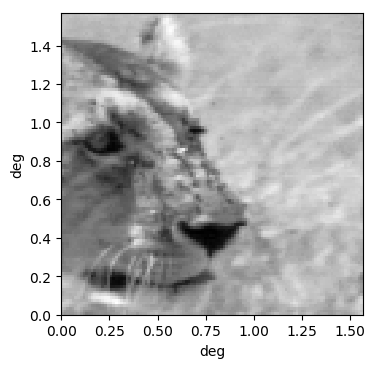

In [12]:
#show a sample image
def getsim(idx):
    sampleim = m[idx]
    return(sampleim)
    
#plt.imshow(sampleim,cmap='gray') #doesn't look quite as good.
#fig = plt.imshow(getsim(lion),cmap='Greys_r') #this map looks a bit better.

fig, ax = plt.subplots()
showim = getsim(lion) #- getsim(lion+1)
ax.imshow(showim, cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

In [13]:
## helper functions for animation

##embed animation as html

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML


#function we can call to animate with HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

#vanilla animation function
def animate(i):
    im.set_array(clip[i,:,:])
    return im,

In [14]:
##play the moive
samplevid = zebra
vidlen = 500

clip = m[samplevid:samplevid+vidlen,:,:]
cliplen = len(clip[:,1,1])

if(1):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
display_animation(anim)

In [15]:
# calculate difference (Dong & Atick 1995a, Figure 1)
def cdiff(fstart, dtms):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    diffim : numpy matrix with pixel values for dif between frames.
    
    """

    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1, fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))
    #time separation in frames
    df = ms2fr(dtms, fps)
    diff = abs(m[fstart,:,:].astype(int) - m[fstart+df,:,:].astype(int))
    return(diff)

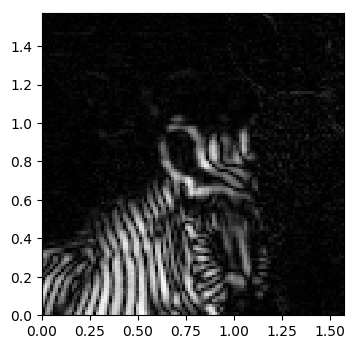

In [16]:
diffim = cdiff(zebra, 40)
plt.imshow(diffim,cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

# Cross Correlation

In [18]:
#average over all pixles
# calculate cross correlation (Dong & Atick 1995a)

##time separation in miliseconds at 25 fps min separation is 40ms.
dtms = 100
#time separation in frames
df = int(dtms * fps  /1000)
j = lion
onecc = np.corrcoef(vm[j,:], vm[j+df,:])
print(onecc)

[[ 1.          0.88686518]
 [ 0.88686518  1.        ]]


## Spatial Fourier Transform of One Raw Image

In [19]:
# from https://code.google.com/archive/p/agpy/downloads
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=complex)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    radial_prof = radial_prof[:int(np.floor(framew/2))-1]

    return radial_prof

In [20]:
def spatialft(image):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    ft2d = np.fft.fftshift(np.fft.fft2(image))
    
    #average over all orientations
    ft1d = azimuthalAverage(ft2d)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return(image, ft2d, ft1d, freq1d)

In [21]:
image, ft2d, ft1d, freq1d = spatialft(getsim(zebra))

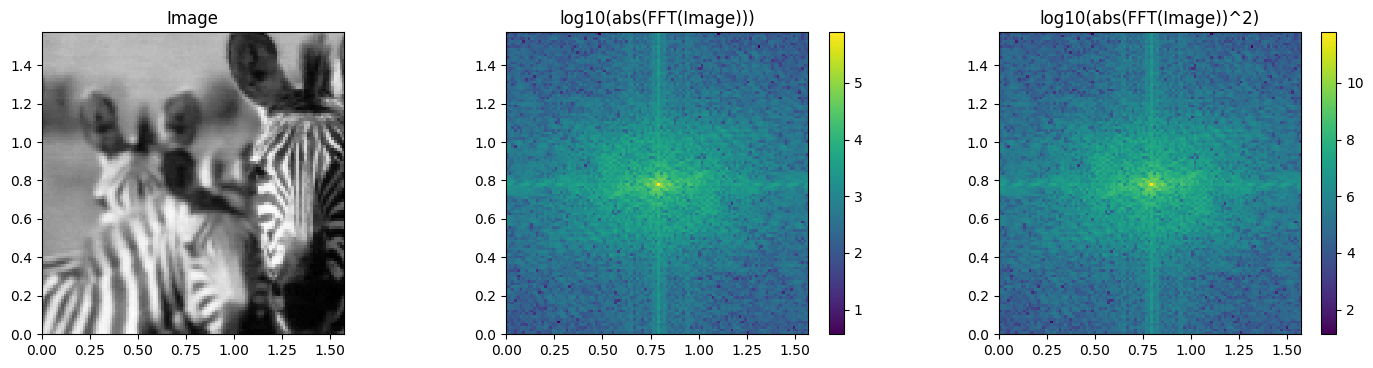

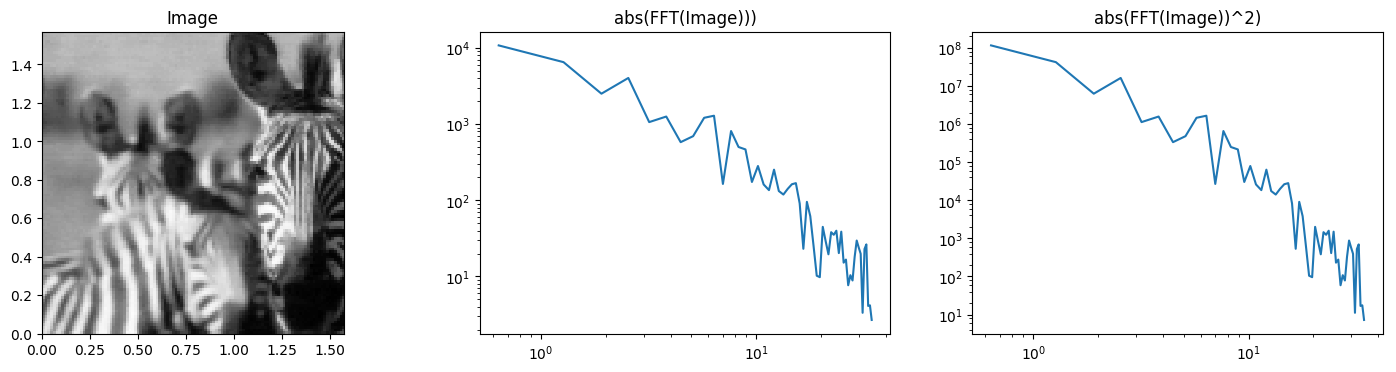

In [22]:
##plotting
#2d power spectra
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

plt.subplot(1,3,2,title='log10(abs(FFT(Image)))')
#plt.imshow(amp2D)
plt.imshow(np.log10(np.abs(ft2d)), interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

plt.subplot(1,3,3,title='log10(abs(FFT(Image))^2)')
#plt.imshow(psf2D)
plt.imshow(np.log10(np.abs(ft2d)**2), interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

##azimuthal average
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', interpolation='none', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

fig = plt.subplot(1,3,2,title='abs(FFT(Image)))')
plt.loglog(freq1d, np.abs(ft1d))

fig = plt.subplot(1,3,3,title='abs(FFT(Image))^2)')
plt.loglog(freq1d, np.abs(ft1d)**2)

plt.show()

## Average Spatial Fourier Transform over Many Images

In [23]:
def avgspatialft(movie):

    #take fourier transform over each fame
    fttimecube = np.fft.fft2(movie)
    
    #average over frames
    ftframemean = np.fft.fftshift(fttimecube.mean(axis=0))

    ##average over all orientations
    ft1dframemean = azimuthalAverage(ftframemean)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return ftframemean, ft1dframemean, freq1d

In [24]:
ftframemean, ft1dframemean, freq1d = avgspatialft(m)

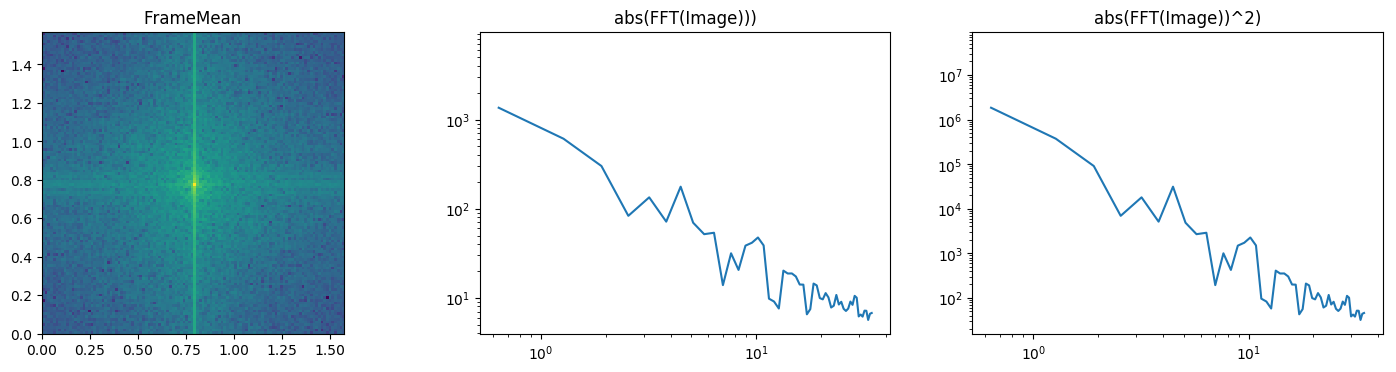

In [25]:
##plotting

##azimuthal average
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='FrameMean')
plt.imshow(np.log10(np.abs(ftframemean)), interpolation='none', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

fig = plt.subplot(1,3,2,title='abs(FFT(Image)))')
plt.loglog(freq1d, np.abs(ft1dframemean))

fig = plt.subplot(1,3,3,title='abs(FFT(Image))^2)')
plt.loglog(freq1d, np.abs(ft1dframemean)**2)

plt.show()

## Pairwise Probability Distribution (Temporal)

In [26]:
# calculate ppd (Dong & Atick 1995a, Figure 2)
def gettemporalppd(fstart, fend, dtms):
    """
    calculated pairwise probability distribution

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    ppd : numpy matrix with pairwise probability distribution.
    
    """
    
    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1,fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))    
    #time separation in frames
    df = ms2fr(dtms, fps)
    
    #levels of light intensity
    lil = 256
    #initialize blank matrix to tally pairs
    ppd = np.zeros((lil,lil))
    #go through all pixels and tally up light intensity pairs
    
    for f in range(fstart,fend-df):
        s1 = vm[f,:]
        s2 = vm[f+df,:]
        for i in range(np.size(s1)):
            ppd[s1[i],s2[i]]+=1
    return(ppd)

/home/vasha/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


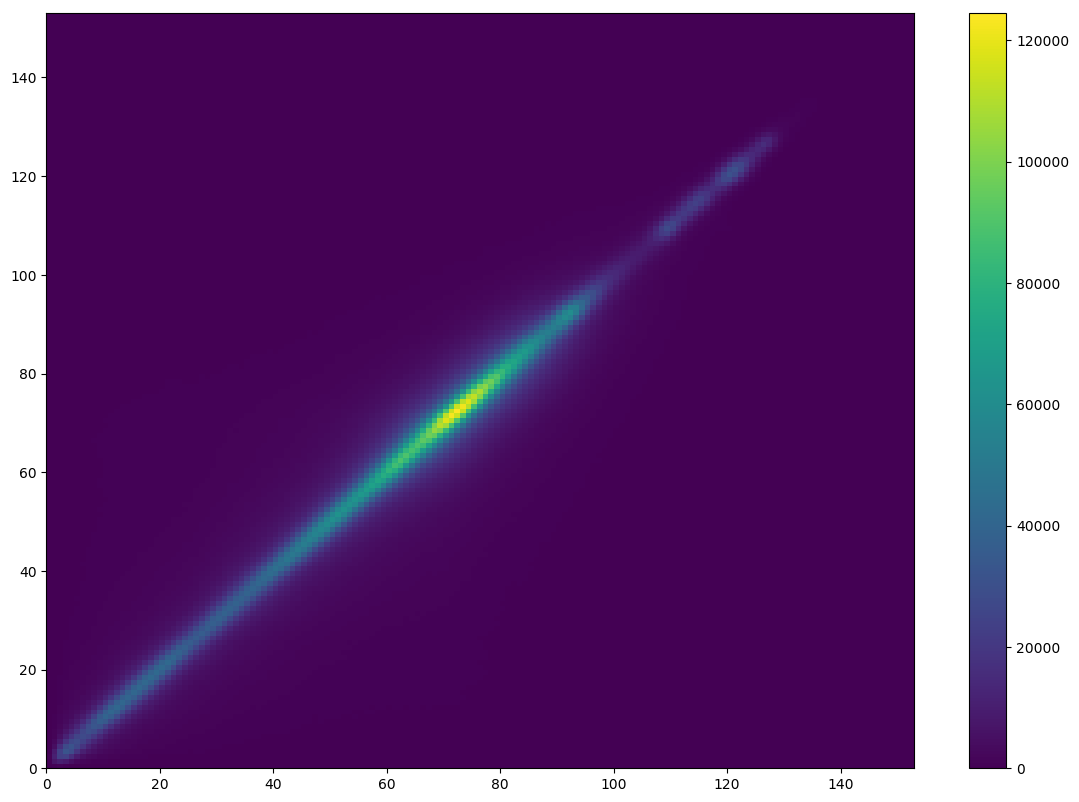

In [27]:
dt = 40*2
myppd = gettemporalppd(0,len(vm),dt)

plt.figure(figsize=(14,10))
plt.pcolormesh(myppd,cmap='viridis')
plt.xlim(0,153)
plt.ylim(0,153)
plt.colorbar()

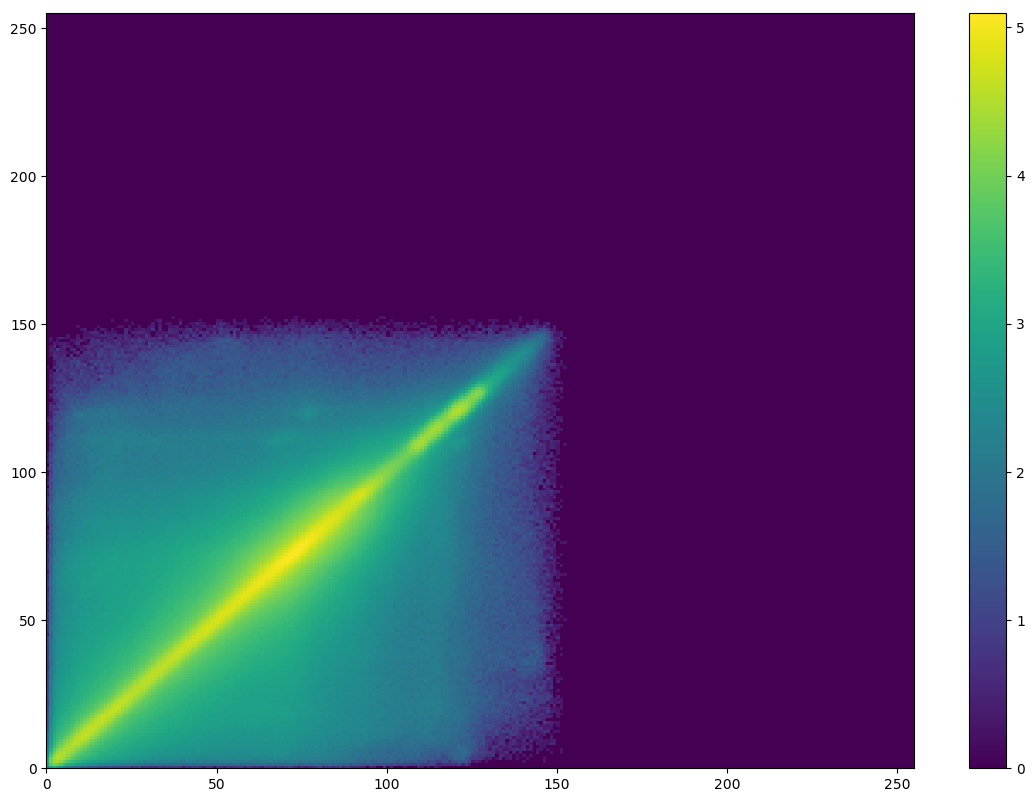

In [28]:
mylppd = np.log10(myppd+1)
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='viridis')
plt.xlim(0,255)
plt.ylim(0,255)
plt.colorbar()

## Where are the cuts?

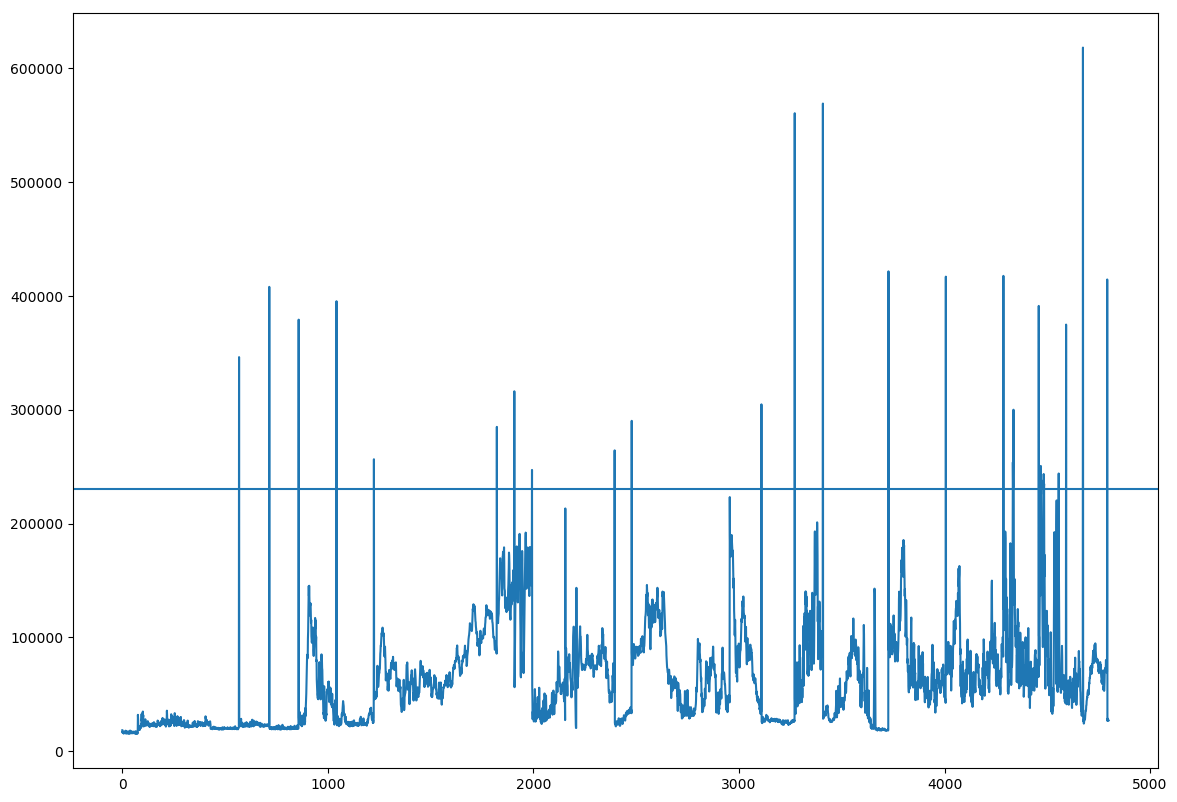

In [29]:
fchange = np.zeros(len(m)-1)
for f in range(len(m)-1):
    fchange[f] = np.sum(cdiff(f, 40))

plt.figure(figsize=(14,10))
plt.plot(fchange)
        
plt.axhline(230000)

## Ignore cuts for now and take 3DFFT

In [30]:
stft = np.fft.rfftn(mm,axes=[0]) #time fourier transform
stfq = np.fft.fftfreq(mm[:,0,0].size, d=1./fps)

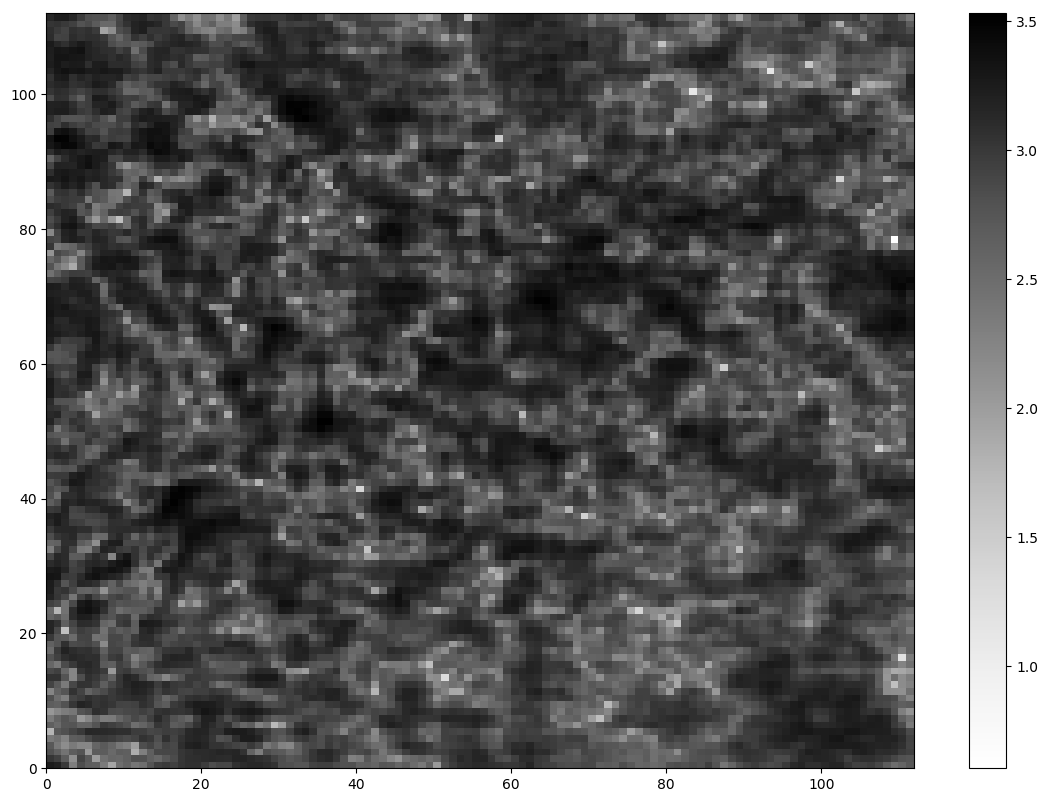

In [31]:
mylppd = np.log10(np.abs(stft[int(zebra/2+3),:,:]+1))
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='Greys')
plt.colorbar()

In [32]:
##play the moive
if(0):
    samplevid = 0
    vidlen = 5000 #in frames

    #if we don't take the log you can't see much.
    clip = np.log10(stft[samplevid:samplevid+vidlen,:,:])
    cliplen = len(clip[:,1,1])

    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)

    display_animation(anim)
    anim.save('./movies/fps_'+fps+'temporalfftlog.mp4', fps=fps,bitrate=-1)

## Average over Many Clips & Make the Football

In [33]:
def make_tdft(movie,fchunk):
    if(fchunk%2 != 0):
        raise Exception('Error, fchunk must be an even number!')

    nchunks = int(np.floor(len(movie[:,0,0])/fchunk))
    
    #take fourier transform over each fame
    fttimecube = np.fft.fft2(movie)
    
    chunklist = []
    
    #break into chunks
    for chunk in range(nchunks):
        chunkmov = fttimecube[chunk*fchunk:(chunk+1)*fchunk]
        #space FT for each chunk
        chunklist.append(np.fft.fftn(chunkmov,axes=[0]))
    chunklist=np.array(chunklist)
    #mean of chunks
    mftchunk = np.mean(chunklist,axis=0)
    
    #do fft shifts to make football
    mftchunk = np.fft.fftshift(mftchunk)
    
    #array to hold azmaverage
    azmchunk = np.zeros([fchunk,int(np.floor(framew/2))-1], dtype=complex)
    
    ##spin to get mean
    for f in range(fchunk):
        azmchunk[f] = azimuthalAverage(np.abs(mftchunk[f]))
        
    azmchunk = (azmchunk[int(fchunk/2):] + azmchunk[int(fchunk/2):0:-1]) / 2
      
    #get the sampling rate for azmavgd
    freqspace1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    #get the sampling rates
    freqspacefull = np.fft.fftshift(np.fft.fftfreq(framew, d=1./ppd))
    freqtime = np.fft.fftshift(np.fft.fftfreq(fchunk, d=1./fps))[int(fchunk/2):]
    
    return mftchunk, azmchunk, freqspace1d, freqspacefull, freqtime

In [34]:
#how many frames in movie?
nframes =150

##call function to take mean FT in space.
football, azmchunk, fqspace1d, fqspacefull, fqtime = make_tdft(m, nframes)

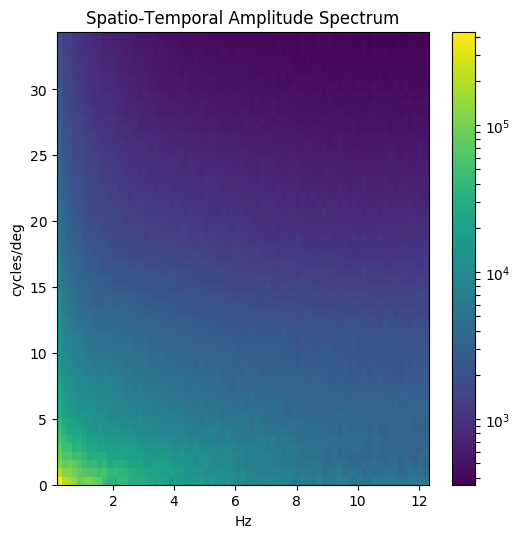

In [35]:
plt.figure(figsize=(6,6))
plt.pcolormesh(fqtime[1:], fqspace1d, np.abs(azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(azmchunk.T[1:,1:]).min(), vmax=np.abs(azmchunk.T[:,1:]).max()))

plt.xlim(fqtime[1],np.max(fqtime))
plt.ylim(0,np.max(fqspace1d[1:]))

plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.title('Spatio-Temporal Amplitude Spectrum')

plt.colorbar()

(150, 112, 112)

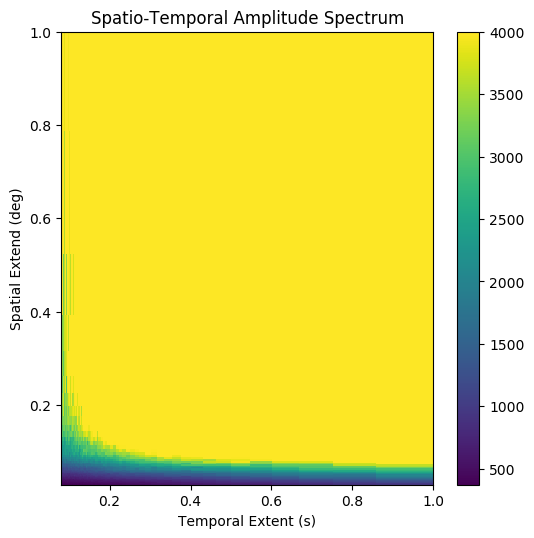

In [36]:
plt.figure(figsize=(6,6))
plt.pcolormesh(1/(fqtime[1:]),
               1/(fqspace1d[1:]),
               np.abs(azmchunk[1:,1:].T), vmax=4000)
#                norm=mpl.colors.LogNorm(vmin=90,
#                                         vmax=11000))

plt.xlim(np.min(1/(fqtime[1:])),1)
plt.ylim(np.min(1/(fqspace1d[1:])),1)
plt.colorbar()
plt.xlabel('Temporal Extent (s)')
plt.ylabel('Spatial Extend (deg)')
plt.title('Spatio-Temporal Amplitude Spectrum')
np.shape(football)

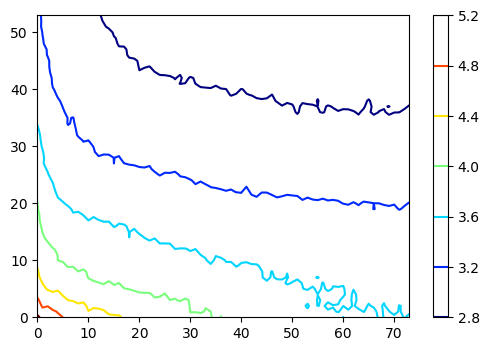

In [37]:
## kelly plot
plt.figure()
plt.contour(np.log10(np.abs(azmchunk[1:,1:]).T),cmap='jet') #remove dc component (0hz) from time and 0 cycles/deg from space
plt.colorbar()

## Sample from Spatial Frequency Spectrum

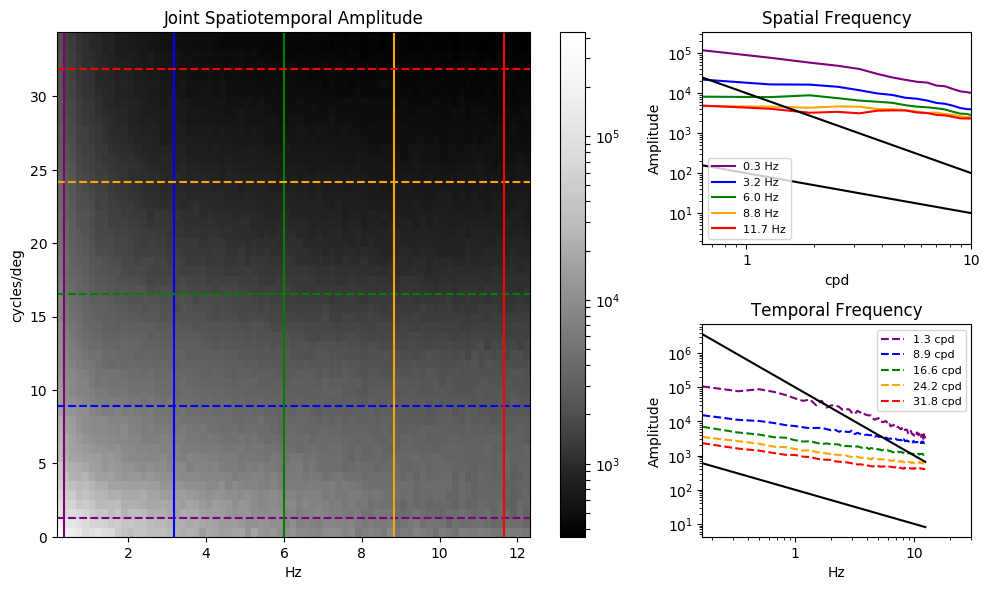

In [38]:
nsamples = 5

spacemin = 2
spacemax = len(fqspace1d)-5
timemin = 2
timemax = len(fqtime)-5


#colors for lines
spacesamplefqs = np.linspace(spacemin,spacemax,nsamples).astype(int)
timesamplefqs = np.linspace(timemin,timemax,nsamples).astype(int)

spacecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]
timecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, np.abs(azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(azmchunk.T[1:,1:]).min(), 
                                      vmax=np.abs(azmchunk.T[:,1:]).max()),
                  cmap='Greys_r')
axes_hm.set_xlim(fqtime[1],np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Amplitude')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, np.abs(azmchunk.T)[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],100/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],100000/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Amplitude') 
axes_time.set_xlim(fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, np.abs(azmchunk.T)[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],100/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],10000/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Amplitude')
axes_space.set_xlim(fqspace1d[1],10)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

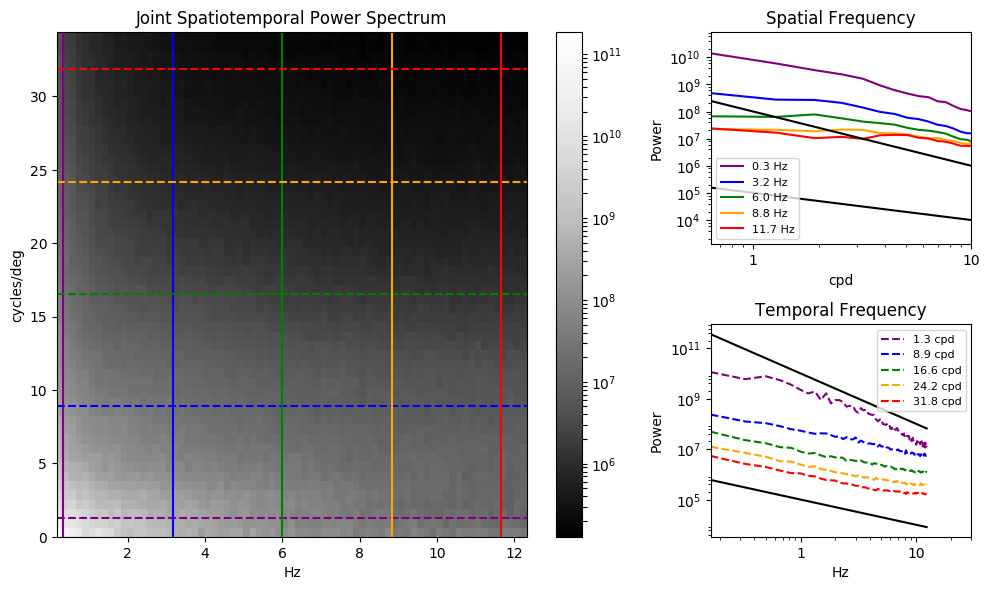

In [39]:
nsamples = 5

spacemin = 2
spacemax = len(fqspace1d)-5
timemin = 2
timemax = len(fqtime)-5

azmps = np.abs(azmchunk.T)**2

#colors for lines
spacesamplefqs = np.linspace(spacemin,spacemax,nsamples).astype(int)
timesamplefqs = np.linspace(timemin,timemax,nsamples).astype(int)

spacecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]
timecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, azmps[:,1:],
              norm=mpl.colors.LogNorm(vmin=azmps[:,1:].min(), 
                                      vmax=azmps[:,1:].max()),
                  cmap='Greys_r')
axes_hm.set_xlim(fqtime[1],np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Power Spectrum')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, azmps[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],1e5/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],1e10/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Power') 
axes_time.set_xlim(fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, azmps[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],1e5/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],1e8/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Power')
axes_space.set_xlim(fqspace1d[1],10)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

## Low Pass Filter Every Other Frame

In [40]:
def lpf2sigma(cutoff):
    """
    Converts cuttoff frequency in cycles/deg
    to a value for sigma (in pixels) for a gaussian kernel.
    Used for low pass filtering for FWHM

    Parameters
    ----------
    fcu: integer Low pass frequncy cuttoff (in cycles per deg)
 
    Returns
    -------
    sigma : float value for sigma (in pixels)
    
    """
    #http://www.ltrr.arizona.edu/~dmeko/notes_8.pdf
    cpp = cutoff/ppd
    sigma = (1./cpp)/6
    return(sigma)


## function to low pass filter frames
def lpf_frames(movie,plpf,cutfqdeg):
    """
    Low pass filters a fraction of frames in a movie.

    Parameters
    ----------
    movie:   numpy matrix with pixel values for movie
    plpf:    percentage of frames to low pass filter ie nlpf=0.25 means 25% of frames are lpf'd
    cutfq:   cutoff frequency for blurring in cycles per degree
    
    Returns
    -------
    lpfmovie       : numpy matrix with pixel values for low pass filtered movie.
    
    """
    
    #calculate sigma for gaussian kernel
    
    cutfqpx = ppd/cutfqdeg #deg2px(1./cutfqdeg) #degrees per cycle to pixels per cycle
    sig = lpf2sigma(1./cutfqpx) #cycles per pixel to pixels
    
    lpfmov = np.zeros_like(movie)
    
    for i in range(len(movie[:,0,0])):
        frame = movie[i,:,:]
        if ((plpf < 0.5) & (i % round(1/plpf) == 0)) | (i % round(1/(1-plpf)) != 0):
            gain = ndimage.gaussian_filter(np.ones_like(frame), sigma=sig)
            filtered = ndimage.gaussian_filter(frame, sigma=sig)
            lpfmov[i,:,:] = filtered/gain
        else:
            lpfmov[i,:,:] = frame
    return(lpfmov)

In [41]:
#make filtered movie
pframes = 0.5
cufq = 5
fmov = lpf_frames(m,pframes,cufq)
# fmov = lpf_frames(fmov,0.5,1.5)
# fmov = lpf_frames(fmov,0.5,1.5)
##call function to take mean FT in space.
filtered_football, filtered_azmchunk, filtered_fqspace1d, filtered_fqspacefull, filtered_fqtime = make_tdft(fmov, nframes)

In [42]:
## animate, play, and save the moive, unfiltered, filtered, and separated into even/odd 
samplevid = chase
vidlen = 2000

pframe = 0.5
cufqs = 1 #[1,3,5,8]

for cufq in cufqs:
    print('cufq'+str(cufq))

    clip = fmov[samplevid:samplevid+vidlen,:,:]
    cliplen = len(clip[:,1,1])

    #encode together
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    #display_animation(anim)
    anim.save('./movies/'+str(samplevid)+'_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)


    #encode separate
    evens = [x for x in range(samplevid,samplevid+vidlen) if x%2 == 0]
    clip = fmov[evens,:,:]
    cliplen = len(clip[:,1,1])
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
        anim.save('./movies/'+str(samplevid)+'odds_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)

    odds = [x for x in range(samplevid,samplevid+vidlen) if x%2 == 1]
    clip = fmov[odds,:,:]
    cliplen = len(clip[:,1,1])
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
        anim.save('./movies/'+str(samplevid)+'evens_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)


    ##make corresponding unfiltered movie
    from pathlib import Path

    my_file = Path('./movies/'+str(samplevid)+'_original.mp4')
    if not(my_file.is_file()):
        clip = m[samplevid:samplevid+vidlen,:,:]
        cliplen = len(clip[:,1,1])

        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)

        #display_animation(anim)
        anim.save('./movies/'+str(samplevid)+'_fps'+str(fps)+'_original.mp4', fps=fps)

TypeError: 'int' object is not iterable

In [ ]:
#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, np.abs(filtered_azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(filtered_azmchunk.T[1:,1:]).min(), 
                                      vmax=np.abs(filtered_azmchunk.T[:,1:]).max()),
                  cmap='Greys_r')
axes_hm.set_xlim(filtered_fqtime[1],np.max(filtered_fqtime))
axes_hm.set_ylim(0,np.max(filtered_fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Amplitude')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(filtered_fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(filtered_fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(filtered_fqtime, np.abs(filtered_azmchunk.T)[sf,:],'--',
                   label='{0:0.1f} cpd'.format(filtered_fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(filtered_fqtime[1:],100/(filtered_fqtime[1:]),c='black') # 1/f line
axes_time.plot(filtered_fqtime[1:],100000/(filtered_fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Amplitude')
axes_time.set_xlim(filtered_fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(filtered_fqspace1d, np.abs(filtered_azmchunk.T)[:,sf],
                    label='{0:0.1f} Hz'.format(filtered_fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(filtered_fqspace1d[1:],100/(filtered_fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(filtered_fqspace1d[1:],5000/(filtered_fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Amplitude') 
axes_space.set_xlim(filtered_fqspace1d[1],10)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

In [ ]:
filtered_azmps = np.abs(filtered_azmchunk.T)**2

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, filtered_azmps[:,1:],
              norm=mpl.colors.LogNorm(vmin=filtered_azmps[:,1:].min(), 
                                      vmax=filtered_azmps[:,1:].max()),
                  cmap='Greys_r')
axes_hm.set_xlim(fqtime[1],10)#np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Power Spectrum')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, filtered_azmps[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],1e5/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],1e10/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Power') 
axes_time.set_xlim(fqtime[1],30) #fqtime[-1])
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, filtered_azmps[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],1e5/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],1e8/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Power')
axes_space.set_xlim(fqspace1d[1],10)#fqspace1d[-1])
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

In [ ]:
difference = np.abs(azmchunk) - np.abs(filtered_azmchunk)

plt.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, difference.T[:,1:],
               cmap='Greys_r')
plt.xlim(filtered_fqtime[1],np.max(filtered_fqtime))
plt.ylim(0,np.max(filtered_fqspace1d[1:]))
plt.title('Amplitude of Original minus Filtered')
plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

In [ ]:
difference = np.abs(azmps) - np.abs(filtered_azmps)

plt.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, difference[:,1:],
               cmap='Greys_r')
plt.xlim(filtered_fqtime[1],np.max(filtered_fqtime))
plt.ylim(0,np.max(filtered_fqspace1d[1:]))
plt.title('Power of Original minus Filtered')
plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

## Cut out a spatio/temporal corner in Fourier space so we don't have flicker

In [ ]:
def make_fft_filter(shape, scaling_space=1, scaling_time=1, cut_strength=1):
    filt = np.ones(shape)
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                #make a radius of our falloff over all shapes so we weight equally
                r = np.sqrt((scaling_time*x/shape[0])**2
                            + (scaling_space*y/shape[1])**2 
                            + (scaling_space*z/shape[2])**2)
                filt[x,y,z] = np.exp((-r**(2*cut_strength)))
    return(filt)

def animate_filt(i):
    im.set_array(filt_movie[i,:,:])
    return im,

In [ ]:
#choose a clip
samplevid = chase
vidlen = 2000
clip = m[samplevid:samplevid+vidlen,:,:]
clipbigfootball = np.fft.fftn(clip)

#parameters for filtering
#ss =  1 #a number between 0 and 1+, where 1 cutts off few high spatial frequencies
#st =  1 #a number between 0 and 1+, where 1 cutts off few high temporal frequencies
#co_str = 3 # a number between 1 and 10, how steep the gaussian cuttoff is.

#vals for filtering
ss_vals = [0.5,0.75] #[0,0.5,0.75,1,2]
st_vals = [0.5,0.75] #[0,0.5,0.75,1,2]
co_str_vals = [3,6] #[1,3,6,8]

if(1):
    #loop through vals
    for ss in ss_vals:
        for st in st_vals:
            for co_str in co_str_vals:
                print('Filtering Movie: SS='+str(ss)+ ' ST='+str(st)+ ' CO='+str(co_str))

                #get our filtered movie
                filt = make_fft_filter(np.shape(clipbigfootball), 
                                       scaling_space = ss, scaling_time=st, cut_strength=co_str)

                filt_football = clipbigfootball * filt

                filt_movie = np.round(np.abs(np.fft.ifftn(filt_football))).astype(int)

                #trick to match contrast
                filt_movie[0,0,0] = 0
                filt_movie[0,0,1] = 143

                fig = plt.figure();
                im = plt.imshow(filt_movie[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg]);
                anim = animation.FuncAnimation(fig, animate_filt, frames=range(len(filt_movie)), interval=int(100/len(filt_movie)), blit=False)

                #display_animation(anim)
                anim.save('./movies/newmovies/'+str(samplevid)+'_fps'+str(fps)+
                          '_scalespace'+str(ss)+'_scaletime'+str(st)+'costr'+str(co_str)+'.mp4', fps=fps)



In [ ]:
f = make_fft_filter(np.shape(clipbigfootball), 
                                       scaling_space = 0.5, scaling_time=0.75, cut_strength=3)


In [ ]:
print(f)

In [ ]:
plt.imshow(filt_movie[10,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])

In [ ]:
plt.imshow(np.abs(clip[10,:,:]), cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])

In [ ]:
fig = plt.figure()
im = plt.imshow(filt_movie[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
anim = animation.FuncAnimation(fig, animate_filt, frames=range(len(filt_movie)), interval=int(100/len(filt_movie)), blit=False)

#display_animation(anim)
anim.save('./movies/'+str(samplevid)+'_fps'+str(fps)+
          '_scalespace'+str(ss)+'_scaletime'+str(st)+'costr'+str(co_str)+'.mp4', fps=fps)




In [ ]:
np.save('./filteredfootball.npy', filt_football)
np.save('./filteredmovie.npy', filt_movie)
filt_football = np.load('./filteredfootball.npy')
filt_movie = np.load('./filteredmovie.npy')

In [ ]:
filt.shape
filtered_fqtime.shape

In [ ]:
#filt = make_fft_filter(np.shape(clipbigfootball), 
#                                       scaling_space = 0, scaling_time=0, cut_strength=0)


filt = np.ones(np.shape(clipbigfootball))


# plt.figure(figsize=(8,6))
plt.pcolormesh(np.fft.rfftfreq(2000*2, 1/24.),
               np.fft.rfftfreq(112*2, 1/ppd),
               np.reshape(filt[:,:,1],(2000,112)).T,cmap='Greys_r',
               vmin=0, vmax=1)
plt.title('Fourier Filter')

plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

## Meeting with Bruno - Notes to update:  

### Action Items (bold when done)

**Change to chunks so the Rayleigh frequency is on the order of something sensible. Right now it's 1 cycle per the entire movie. Averaging over the chunks will also make the data better.** 

**.64 cycles/images max (nuyquist)**

**0.5 cycles per pixel**

Add powers then take sqrt

Discreet fourier transform - Need tapering function on outside of image (use raised cosine)  Do this in time also

Urs' duck movie (ask dyaln for this) might be a better movie than the VH movie.  

For motion sharpening:
Need to figure out the encoding. Also ask Dylan about ffmpeg, this might be a good way to do it.  

**Adjust for a DC gain of 1 by ensuring filter sums to 1.**

Coinsider boosting low pass frames

Or blending in high pass filter over time (so we don't just have hole - this may stop the flickering. 

## optimal spatial & temporal filters

From Dong, D. W., & Atick, J. J. (1995). Temporal Decorrelation: A Theory of Lagged and Nonlagged Responses in the Lateral Geniculate Nucleus.

$$ K_{LGN}(t) = t(1-\pi w_c t)e^{-2\pi wct} $$

In [ ]:
#cuttoff frequency
wc = 5.5 

#spatial
s = np.linspace(-1,1)
sigpush = 0.05
sigpull = 0.1
kretina = 0.015*np.exp(-(s)**2/((2*sigpush)**2)) - \
          0.005*np.exp(-(s)**2/((2*sigpull)**2))      #s/((1+(s**2)/(wc**2))**(3/2))

#temporal
t = np.linspace(0,8*0.033)
klgn = t*(1-np.pi*wc*t)*np.exp(-2*np.pi*wc*t)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(s,kretina)
ax1.set_title('Optimal Spatial Filter')
l = plt.axhline(0,c='black')
ax1.set_xlabel('Space')
ax1.set_ylabel('Response')
ax2.plot(t,klgn)
ax2.axhline(0,c='black')
ax2.set_title('Optimal Temporal Filter')
ax2.set_xlabel('Time')



In [ ]:
np.shape(rfw)